# Project 4: West Nile Virus Prediction
____________

# Part 3 - Preprocessing, Modelling, Evaluation

### Group 4, SG-DSI-18

## Problem Statement

West Nile Virus (Wnv), a mosquito-bourne arbovirus, has been causing significant and sometimes severe human diseases. Although pesticides are known to be effective in dealing with the virus-carrying mosquitoes, it is expensive to deploy pesticides throughout the city. As data scientists in the Division of Societal Cures in Epidemiology & New Creative Engineering, we want to understand the factors driving the spread of Wnv by leveraging on data collected by Chicago's weather stations and the surveillance system set up by the Chicago Department of Public Health. We also want to develop a classfication model that could predict the presence of Wnv within the area of Windy City. Through these studies, we hope to suggest a cost-efficient and effective method of deploying pesticides within the area.

## Executive Summary

This project is part of a [Kaggle competition](https://www.kaggle.com/c/predict-west-nile-virus/overview) and explores data collected from various sources, namely:  
* Mosquito trap data collected by the surveillance and control system
* Location data of spraying efforts
* Weather data

The data from these three sources were combined to form a more wholesome dataset for analysis and modelling. The spray data was used to create a feature indicating if each mosquito trap was within the spray zone over a period of 30 days from the spray date. The weather data was added to the combined dataset based on date and location.

Several classifier models were developed, where the hyperparameters were tuned for each model to obtain the best cross-validated AUC scores. Because there were heavy imbalances in the data collected (about 95% of the data indicated no Wnv), an over-sampling method known as SMOTE (Synthetic Minority Over-sampling Technique) was adopted. It was also the reason for optimizing the models on AUC scores instead of accuracy. Comparing the AUC and recall scores, the production model selected was the AdaBoost model. Comparing the train and test accuracy scores of the selected model, there was evidence of slight overfitting of the data but the small difference was acceptable by our means.

We discovered that the time of the day where the sun is out was where the presence of Wnv was the strongest. Also, we observed that the more competent vectors for the spread of Wnv were the culex pipiens and culex restuans species. In order to deploy pesticides in a more cost-efficient way, we recommend spraying in areas where culex pipiens/restuans are most prominent and during the day as the Sun rises where the mosquitoes are most active.

We also explored into deep learning and neural networks. However, our neural network did not outperform the selected model, likely due to the fact it had low complexity. We decided not to further develop the deep learning model since it is not easily interpretable and we had to keep within the limited timeframe of this project.

### Contents:
- [Modelling & Hyperparameter Tuning](#Modelling-&-Hyperparameter-Tuning)
- [Model Evaluation & Selection](#Model-Evaluation-&-Selection)
- [Deep Learning with Neural Network](#Deep-Learning-with-Neural-Network)
- [Conclusions](#Conclusions)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, precision_recall_fscore_support,  roc_auc_score
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics

# Imports for geospatial data visualizations
import folium
from folium.plugins import HeatMapWithTime
from branca.element import Figure

### Import data

In [2]:
# Use this to load previously saved .pkl file
infile = open('../datasets/combined_training.pkl', 'rb')
df = pickle.load(infile)
infile.close()

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df.head()

,Date,WnvPresent,species_no,trap_sprayed,WeekTavg,WeekWetBulb,WeekWetDry,WeekPrecipTotal,WeekStnPressure,WeekSeaLevel,WeekResultSpeed,WeekResultDir,WeekAvgSpeed,WeekSunHours,WeekHumidity,templag1,templag2,templag3,templag4,wetbulblag1,wetbulblag2,wetbulblag3,wetbulblag4,wetdrylag1,wetdrylag2,wetdrylag3,wetdrylag4,preciplag1,preciplag2,preciplag3,preciplag4,stnpressurelag1,stnpressurelag2,stnpressurelag3,stnpressurelag4,sealevellag1,sealevellag2,sealevellag3,sealevellag4,resultspdlag1,resultspdlag2,resultspdlag3,resultspdlag4,resultdirlag1,resultdirlag2,resultdirlag3,resultdirlag4,windlag1,windlag2,windlag3,windlag4,sunlag1,sunlag2,sunlag3,sunlag4,humidlag1,humidlag2,humidlag3,humidlag4,Trap_T001,Trap_T002,Trap_T003,Trap_T004,Trap_T005,Trap_T006,Trap_T007,Trap_T008,Trap_T009,Trap_T011,Trap_T012,Trap_T013,Trap_T014,Trap_T015,Trap_T016,Trap_T017,Trap_T018,Trap_T019,Trap_T025,Trap_T027,Trap_T028,Trap_T030,Trap_T031,Trap_T033,Trap_T034,Trap_T035,Trap_T036,Trap_T037,Trap_T039,Trap_T040,Trap_T043,Trap_T044,Trap_T045,Trap_T046,Trap_T047,Trap_T048,Trap_T049,Trap_T050,Trap_T051,Trap_T054,Trap_T054C,Trap_T060,Trap_T061,Trap_T062,Trap_T063,Trap_T065,Trap_T066,Trap_T067,Trap_T069,Trap_T070,Trap_T071,Trap_T072,Trap_T073,Trap_T074,Trap_T075,Trap_T076,Trap_T077,Trap_T078,Trap_T079,Trap_T080,Trap_T081,Trap_T082,Trap_T083,Trap_T084,Trap_T085,Trap_T086,Trap_T088,Trap_T089,Trap_T090,Trap_T091,Trap_T092,Trap_T094,Trap_T094B,Trap_T095,Trap_T096,Trap_T097,Trap_T099,Trap_T100,Trap_T102,Trap_T103,Trap_T107,Trap_T114,Trap_T115,Trap_T128,Trap_T129,Trap_T135,Trap_T138,Trap_T141,Trap_T142,Trap_T143,Trap_T144,Trap_T145,Trap_T146,Trap_T147,Trap_T148,Trap_T149,Trap_T150,Trap_T151,Trap_T152,Trap_T153,Trap_T154,Trap_T155,Trap_T156,Trap_T157,Trap_T158,Trap_T159,Trap_T160,Trap_T161,Trap_T162,Trap_T200,Trap_T206,Trap_T209,Trap_T212,Trap_T215,Trap_T218,Trap_T219,Trap_T220,Trap_T221,Trap_T222,Trap_T223,Trap_T224,Trap_T225,Trap_T226,Trap_T227,Trap_T228,Trap_T229,Trap_T230,Trap_T231,Trap_T232,Trap_T233,Trap_T235,Trap_T236,Trap_T237,Trap_T238,Trap_T900,Trap_T903
0,2007-05-29,0,2.0,0,74.142857,64.714286,0.714286,0.152143,29.267143,29.921429,6.6,17.142857,7.585714,14.980952,57.142857,68.714286,61.571429,64.571429,60.333333,58.0,50.571429,54.714286,50.0,0.571429,0.428571,0.285714,0.166667,0.065,0.111429,0.003571,0.000833,29.448571,29.422857,29.402857,29.42,30.097143,30.08,30.062857,30.071667,8.042857,9.285714,6.814286,10.666667,15.428571,18.714286,12.714286,9.5,10.0,10.857143,8.357143,12.1,14.809524,14.6,14.361905,14.111111,46.042857,41.685714,48.014286,45.383333,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2007-05-29,0,1.0,0,74.142857,64.714286,0.714286,0.152143,29.267143,29.921429,6.6,17.142857,7.585714,14.980952,57.142857,68.714286,61.571429,64.571429,60.333333,58.0,50.571429,54.714286,50.0,0.571429,0.428571,0.285714,0.166667,0.065,0.111429,0.003571,0.000833,29.448571,29.422857,29.402857,29.42,30.097143,30.08,30.062857,30.071667,8.042857,9.285714,6.814286,10.666667,15.428571,18.714286,12.714286,9.5,10.0,10.857143,8.357143,12.1,14.809524,14.6,14.361905,14.111111,46.042857,41.685714,48.014286,45.383333,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2007-05-29,0,1.0,0,74.142857,64.714286,0.714286,0.152143,29.267143,29.921429,6.6,17.142857,7.585714,14.980952,57.142857,68.714286,61.571429,64.571429,60.333333,58.0,50.571429,54.714286,50.0,0.571429,0.428571,0.285714,0.166667,0.065,0.111429,0.003571,0.000833,29.448571,29.422857,29.402857,29.42,30.097143,30.08,30.062857,30.071667,8.042857,9.285714,6.814286,10.666667,15.428571,18.

In [5]:
df.describe()

,WnvPresent,species_no,trap_sprayed,WeekTavg,WeekWetBulb,WeekWetDry,WeekPrecipTotal,WeekStnPressure,WeekSeaLevel,WeekResultSpeed,WeekResultDir,WeekAvgSpeed,WeekSunHours,WeekHumidity,templag1,templag2,templag3,templag4,wetbulblag1,wetbulblag2,wetbulblag3,wetbulblag4,wetdrylag1,wetdrylag2,wetdrylag3,wetdrylag4,preciplag1,preciplag2,preciplag3,preciplag4,stnpressurelag1,stnpressurelag2,stnpressurelag3,stnpressurelag4,sealevellag1,sealevellag2,sealevellag3,sealevellag4,resultspdlag1,resultspdlag2,resultspdlag3,resultspdlag4,resultdirlag1,resultdirlag2,resultdirlag3,resultdirlag4,windlag1,windlag2,windlag3,windlag4,sunlag1,sunlag2,sunlag3,sunlag4,humidlag1,humidlag2,humidlag3,humidlag4,Trap_T001,Trap_T002,Trap_T003,Trap_T004,Trap_T005,Trap_T006,Trap_T007,Trap_T008,Trap_T009,Trap_T011,Trap_T012,Trap_T013,Trap_T014,Trap_T015,Trap_T016,Trap_T017,Trap_T018,Trap_T019,Trap_T025,Trap_T027,Trap_T028,Trap_T030,Trap_T031,Trap_T033,Trap_T034,Trap_T035,Trap_T036,Trap_T037,Trap_T039,Trap_T040,Trap_T043,Trap_T044,Trap_T045,Trap_T046,Trap_T047,Trap_T048,Trap_T049,Trap_T050,Trap_T051,Trap_T054,Trap_T054C,Trap_T060,Trap_T061,Trap_T062,Trap_T063,Trap_T065,Trap_T066,Trap_T067,Trap_T069,Trap_T070,Trap_T071,Trap_T072,Trap_T073,Trap_T074,Trap_T075,Trap_T076,Trap_T077,Trap_T078,Trap_T079,Trap_T080,Trap_T081,Trap_T082,Trap_T083,Trap_T084,Trap_T085,Trap_T086,Trap_T088,Trap_T089,Trap_T090,Trap_T091,Trap_T092,Trap_T094,Trap_T094B,Trap_T095,Trap_T096,Trap_T097,Trap_T099,Trap_T100,Trap_T102,Trap_T103,Trap_T107,Trap_T114,Trap_T115,Trap_T128,Trap_T129,Trap_T135,Trap_T138,Trap_T141,Trap_T142,Trap_T143,Trap_T144,Trap_T145,Trap_T146,Trap_T147,Trap_T148,Trap_T149,Trap_T150,Trap_T151,Trap_T152,Trap_T153,Trap_T154,Trap_T155,Trap_T156,Trap_T157,Trap_T158,Trap_T159,Trap_T160,Trap_T161,Trap_T162,Trap_T200,Trap_T206,Trap_T209,Trap_T212,Trap_T215,Trap_T218,Trap_T219,Trap_T220,Trap_T221,Trap_T222,Trap_T223,Trap_T224,Trap_T225,Trap_T226,Trap_T227,Trap_T228,Trap_T229,Trap_T230,Trap_T231,Trap_T232,Trap_T233,Trap_T235,Trap_T236,Trap_T237,Trap_T238,Trap_T900,Trap_T903
count,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.00000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000

## Preprocessing

In [6]:
df.head()

,Date,WnvPresent,species_no,trap_sprayed,WeekTavg,WeekWetBulb,WeekWetDry,WeekPrecipTotal,WeekStnPressure,WeekSeaLevel,WeekResultSpeed,WeekResultDir,WeekAvgSpeed,WeekSunHours,WeekHumidity,templag1,templag2,templag3,templag4,wetbulblag1,wetbulblag2,wetbulblag3,wetbulblag4,wetdrylag1,wetdrylag2,wetdrylag3,wetdrylag4,preciplag1,preciplag2,preciplag3,preciplag4,stnpressurelag1,stnpressurelag2,stnpressurelag3,stnpressurelag4,sealevellag1,sealevellag2,sealevellag3,sealevellag4,resultspdlag1,resultspdlag2,resultspdlag3,resultspdlag4,resultdirlag1,resultdirlag2,resultdirlag3,resultdirlag4,windlag1,windlag2,windlag3,windlag4,sunlag1,sunlag2,sunlag3,sunlag4,humidlag1,humidlag2,humidlag3,humidlag4,Trap_T001,Trap_T002,Trap_T003,Trap_T004,Trap_T005,Trap_T006,Trap_T007,Trap_T008,Trap_T009,Trap_T011,Trap_T012,Trap_T013,Trap_T014,Trap_T015,Trap_T016,Trap_T017,Trap_T018,Trap_T019,Trap_T025,Trap_T027,Trap_T028,Trap_T030,Trap_T031,Trap_T033,Trap_T034,Trap_T035,Trap_T036,Trap_T037,Trap_T039,Trap_T040,Trap_T043,Trap_T044,Trap_T045,Trap_T046,Trap_T047,Trap_T048,Trap_T049,Trap_T050,Trap_T051,Trap_T054,Trap_T054C,Trap_T060,Trap_T061,Trap_T062,Trap_T063,Trap_T065,Trap_T066,Trap_T067,Trap_T069,Trap_T070,Trap_T071,Trap_T072,Trap_T073,Trap_T074,Trap_T075,Trap_T076,Trap_T077,Trap_T078,Trap_T079,Trap_T080,Trap_T081,Trap_T082,Trap_T083,Trap_T084,Trap_T085,Trap_T086,Trap_T088,Trap_T089,Trap_T090,Trap_T091,Trap_T092,Trap_T094,Trap_T094B,Trap_T095,Trap_T096,Trap_T097,Trap_T099,Trap_T100,Trap_T102,Trap_T103,Trap_T107,Trap_T114,Trap_T115,Trap_T128,Trap_T129,Trap_T135,Trap_T138,Trap_T141,Trap_T142,Trap_T143,Trap_T144,Trap_T145,Trap_T146,Trap_T147,Trap_T148,Trap_T149,Trap_T150,Trap_T151,Trap_T152,Trap_T153,Trap_T154,Trap_T155,Trap_T156,Trap_T157,Trap_T158,Trap_T159,Trap_T160,Trap_T161,Trap_T162,Trap_T200,Trap_T206,Trap_T209,Trap_T212,Trap_T215,Trap_T218,Trap_T219,Trap_T220,Trap_T221,Trap_T222,Trap_T223,Trap_T224,Trap_T225,Trap_T226,Trap_T227,Trap_T228,Trap_T229,Trap_T230,Trap_T231,Trap_T232,Trap_T233,Trap_T235,Trap_T236,Trap_T237,Trap_T238,Trap_T900,Trap_T903
0,2007-05-29,0,2.0,0,74.142857,64.714286,0.714286,0.152143,29.267143,29.921429,6.6,17.142857,7.585714,14.980952,57.142857,68.714286,61.571429,64.571429,60.333333,58.0,50.571429,54.714286,50.0,0.571429,0.428571,0.285714,0.166667,0.065,0.111429,0.003571,0.000833,29.448571,29.422857,29.402857,29.42,30.097143,30.08,30.062857,30.071667,8.042857,9.285714,6.814286,10.666667,15.428571,18.714286,12.714286,9.5,10.0,10.857143,8.357143,12.1,14.809524,14.6,14.361905,14.111111,46.042857,41.685714,48.014286,45.383333,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2007-05-29,0,1.0,0,74.142857,64.714286,0.714286,0.152143,29.267143,29.921429,6.6,17.142857,7.585714,14.980952,57.142857,68.714286,61.571429,64.571429,60.333333,58.0,50.571429,54.714286,50.0,0.571429,0.428571,0.285714,0.166667,0.065,0.111429,0.003571,0.000833,29.448571,29.422857,29.402857,29.42,30.097143,30.08,30.062857,30.071667,8.042857,9.285714,6.814286,10.666667,15.428571,18.714286,12.714286,9.5,10.0,10.857143,8.357143,12.1,14.809524,14.6,14.361905,14.111111,46.042857,41.685714,48.014286,45.383333,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2007-05-29,0,1.0,0,74.142857,64.714286,0.714286,0.152143,29.267143,29.921429,6.6,17.142857,7.585714,14.980952,57.142857,68.714286,61.571429,64.571429,60.333333,58.0,50.571429,54.714286,50.0,0.571429,0.428571,0.285714,0.166667,0.065,0.111429,0.003571,0.000833,29.448571,29.422857,29.402857,29.42,30.097143,30.08,30.062857,30.071667,8.042857,9.285714,6.814286,10.666667,15.428571,18.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8610 entries, 0 to 8609
Columns: 195 entries, Date to Trap_T903
dtypes: datetime64[ns](1), float64(56), int64(2), uint8(136)
memory usage: 5.1 MB


In [8]:
# Setting the variables
X = df[[col for col in df.columns if col not in ['Date', 'WnvPresent', 'YearWeek', 'WeekTavg', 'WeekWetBulb', 'WeekWetDry', 'WeekPrecipTotal', 'WeekStnPressure','WeekSeaLevel', 'WeekResultSpeed', 'WeekResultDir', 'WeekAvgSpeed', 'WeekSunHours', 'WeekHumidity', 'Tavg','WetBulb', 'WetDry', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'SunHours', 'Humidity']]]
y = df['WnvPresent']

In [9]:
X.head()

,species_no,trap_sprayed,templag1,templag2,templag3,templag4,wetbulblag1,wetbulblag2,wetbulblag3,wetbulblag4,wetdrylag1,wetdrylag2,wetdrylag3,wetdrylag4,preciplag1,preciplag2,preciplag3,preciplag4,stnpressurelag1,stnpressurelag2,stnpressurelag3,stnpressurelag4,sealevellag1,sealevellag2,sealevellag3,sealevellag4,resultspdlag1,resultspdlag2,resultspdlag3,resultspdlag4,resultdirlag1,resultdirlag2,resultdirlag3,resultdirlag4,windlag1,windlag2,windlag3,windlag4,sunlag1,sunlag2,sunlag3,sunlag4,humidlag1,humidlag2,humidlag3,humidlag4,Trap_T001,Trap_T002,Trap_T003,Trap_T004,Trap_T005,Trap_T006,Trap_T007,Trap_T008,Trap_T009,Trap_T011,Trap_T012,Trap_T013,Trap_T014,Trap_T015,Trap_T016,Trap_T017,Trap_T018,Trap_T019,Trap_T025,Trap_T027,Trap_T028,Trap_T030,Trap_T031,Trap_T033,Trap_T034,Trap_T035,Trap_T036,Trap_T037,Trap_T039,Trap_T040,Trap_T043,Trap_T044,Trap_T045,Trap_T046,Trap_T047,Trap_T048,Trap_T049,Trap_T050,Trap_T051,Trap_T054,Trap_T054C,Trap_T060,Trap_T061,Trap_T062,Trap_T063,Trap_T065,Trap_T066,Trap_T067,Trap_T069,Trap_T070,Trap_T071,Trap_T072,Trap_T073,Trap_T074,Trap_T075,Trap_T076,Trap_T077,Trap_T078,Trap_T079,Trap_T080,Trap_T081,Trap_T082,Trap_T083,Trap_T084,Trap_T085,Trap_T086,Trap_T088,Trap_T089,Trap_T090,Trap_T091,Trap_T092,Trap_T094,Trap_T094B,Trap_T095,Trap_T096,Trap_T097,Trap_T099,Trap_T100,Trap_T102,Trap_T103,Trap_T107,Trap_T114,Trap_T115,Trap_T128,Trap_T129,Trap_T135,Trap_T138,Trap_T141,Trap_T142,Trap_T143,Trap_T144,Trap_T145,Trap_T146,Trap_T147,Trap_T148,Trap_T149,Trap_T150,Trap_T151,Trap_T152,Trap_T153,Trap_T154,Trap_T155,Trap_T156,Trap_T157,Trap_T158,Trap_T159,Trap_T160,Trap_T161,Trap_T162,Trap_T200,Trap_T206,Trap_T209,Trap_T212,Trap_T215,Trap_T218,Trap_T219,Trap_T220,Trap_T221,Trap_T222,Trap_T223,Trap_T224,Trap_T225,Trap_T226,Trap_T227,Trap_T228,Trap_T229,Trap_T230,Trap_T231,Trap_T232,Trap_T233,Trap_T235,Trap_T236,Trap_T237,Trap_T238,Trap_T900,Trap_T903
0,2.0,0,68.714286,61.571429,64.571429,60.333333,58.0,50.571429,54.714286,50.0,0.571429,0.428571,0.285714,0.166667,0.065,0.111429,0.003571,0.000833,29.448571,29.422857,29.402857,29.42,30.097143,30.08,30.062857,30.071667,8.042857,9.285714,6.814286,10.666667,15.428571,18.714286,12.714286,9.5,10.0,10.857143,8.357143,12.1,14.809524,14.6,14.361905,14.111111,46.042857,41.685714,48.014286,45.383333,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,0,68.714286,61.571429,64.571429,60.333333,58.0,50.571429,54.714286,50.0,0.571429,0.428571,0.285714,0.166667,0.065,0.111429,0.003571,0.000833,29.448571,29.422857,29.402857,29.42,30.097143,30.08,30.062857,30.071667,8.042857,9.285714,6.814286,10.666667,15.428571,18.714286,12.714286,9.5,10.0,10.857143,8.357143,12.1,14.809524,14.6,14.361905,14.111111,46.042857,41.685714,48.014286,45.383333,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,0,68.714286,61.571429,64.571429,60.333333,58.0,50.571429,54.714286,50.0,0.571429,0.428571,0.285714,0.166667,0.065,0.111429,0.003571,0.000833,29.448571,29.422857,29.402857,29.42,30.097143,30.08,30.062857,30.071667,8.042857,9.285714,6.814286,10.666667,15.428571,18.714286,12.714286,9.5,10.0,10.857143,8.357143,12.1,14.809524,14.6,14.361905,14.111111,46.042857,41.685714,48.014286,45.383333,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2.0,0,68.714286,61.571429,64.571429,60.333333,58.0,50.571429,54.714286,50.0,0.571429,0.428571,0.285714,0.

In [10]:
# Save X as a pickle file to be referenced for Kaggle predictions
outfile = open('../datasets/X_train.pkl','wb')
pickle.dump(X, outfile)
outfile.close()

## Modelling & Hyperparameter Tuning

We want to fit all the models using `GridSearchCV` to obtain the different hyperparameters optimized for each model. Using these hyperparameters, we will re-fit the model and obtain and scoring metrics and evaluate these metrics for selection of the production model. We also want to interpret each model to find out which are the more significant features that help the models to predict the results more accurately. From these interpretations we are hoping to obtain some insights in the West Nile Virus epidemic.

In [11]:
# train test split
# shuffle=False to account for timelag
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

### Baseline Prediction

In [12]:
# Look at the proportions of each outcome
y_train.value_counts(normalize=True)

0    0.960508
1    0.039492
Name: WnvPresent, dtype: float64

We observe that the data is heavily imbalanced. We will be 95% accurate if we were to predict all to be the negative class (WNV not present). As such, we will be optimizing our models using AUC score instead of accuracy. We will also deploy SMOTE (Synthetic Minority Over-sampling Technique) to help us with over-sampling.

In [13]:
# Scaling
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [14]:
# Instantiate SMOTE
sm = SMOTE(random_state=42)

Xsm_train, ysm_train = sm.fit_resample(Xs_train, y_train)

In [15]:
# Check proportions after SMOTE
ysm_train.value_counts()

1    6202
0    6202
Name: WnvPresent, dtype: int64

The over-sampled data will only be used when evaluating the train and test scores. When we are applying `GridSearchCV` to tune the hyperparameters, we will need to utilize an `imblearn.Pipeline` object to handle the samplers correctly. 

### Fitting Logistic Regression

In [16]:
# Pipeline
pipe_lr = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('lr', LogisticRegression(solver='newton-cg'))
    ])

# Hyperparameters
lr_params = {
    'lr__C': np.linspace(0.1,1,5),
}

In [17]:
# Instantiate 5-fold GridSearchCV.
gs_lr = GridSearchCV(pipe_lr, param_grid = lr_params, cv=5,
                     scoring='roc_auc',n_jobs=-1,
                     verbose=1)

# Fit GridSearch to training data.
gs_lr.fit(Xs_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   21.4s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                                       ('lr',
                                        LogisticRegression(solver='newton-cg'))]),
             n_jobs=-1,
             param_grid={'lr__C': array([0.1  , 0.325, 0.55 , 0.775, 1.   ])},
             scoring='roc_auc', verbose=1)

In [18]:
gs_lr.best_estimator_

Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('lr', LogisticRegression(C=0.1, solver='newton-cg'))])

In [19]:
lr = LogisticRegression(solver='newton-cg', C=0.1)
lr.fit(Xsm_train, ysm_train)

LogisticRegression(C=0.1, solver='newton-cg')

#### Interpreting Logistic Regression

In [20]:
lr.coef_.shape

(1, 182)

In [21]:
importance = lr.coef_
features = X_train.columns
importance = importance.reshape(lr.coef_.shape[1],1)
imp_lr = pd.DataFrame(importance,
                       index=features,
                       columns=['weights']).sort_values(by='weights', ascending=False)
imp_lr

,weights
windlag1,1.486955
species_no,0.915152
stnpressurelag1,0.815240
sunlag4,0.811597
wetbulblag2,0.799945
...,...
windlag2,-0.597052
preciplag4,-0.602713
resultspdlag4,-0.847483
sunlag1,-0.856653


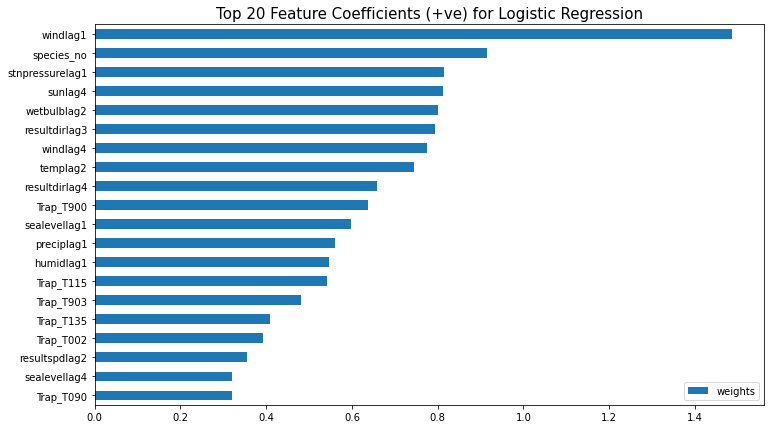

In [22]:
# Plotting top 20 +ve features in bar chart
imp_lr['weights'].head(20).plot(kind='barh', figsize=(12,7))
plt.title('Top 20 Feature Coefficients (+ve) for Logistic Regression', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

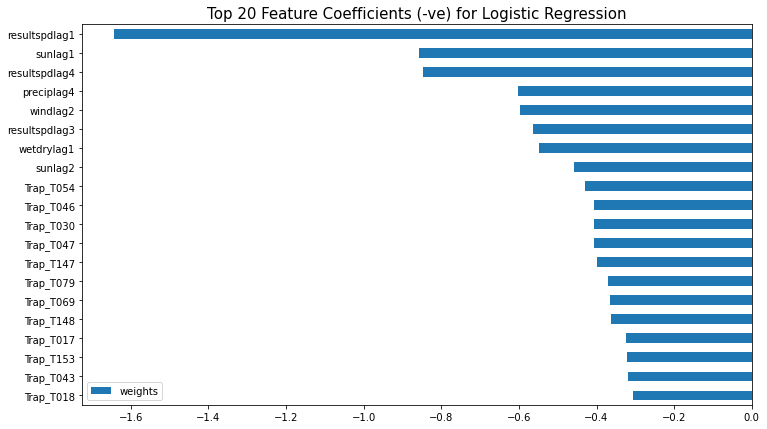

In [23]:
# Plotting top 20 -ve features in bar chart
imp_lr['weights'].tail(20).plot(kind='barh', figsize=(12,7))
plt.title('Top 20 Feature Coefficients (-ve) for Logistic Regression', fontsize=15)
plt.legend(loc=3);

Wetbulb, wind, SeaLevel, species type and temperature are the biggest factors that may affect the presence of the West Nile Virus (Wnv). This suggests that the more humid, wet and warm the conditions are, the higher the chance of Wnv present. The average wind speed has a high negative coefficient which suggests that the higher the wind speed, the lower the chance of Wnv being present. This is expected since if the surroundings are windy, it is much harder for the mosquitoes to fly around. Also, species type plays a major part in the prediction of Wnv since only 3 mosquito species showed that Wnv is present during the EDA.

In [24]:
# Initialize empty list to store all the scores and corresponding model names
model_name = []
model_scores = []
model_var = []
model_test_scores = []

# Append to the lists
model_name.append('Logistic Regression')
model_scores.append(lr.score(Xsm_train, ysm_train))
model_var.append(lr)
model_test_scores.append(lr.score(Xs_test,y_test))

### Fitting Bernoulli Naive Bayes

Naive Bayes classification assumes that the features are independent of one another.

In [25]:
# Pipeline
pipe_bnb = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('bnb', BernoulliNB())
    ])


# Hyperparameters for BernoulliNb
bnb_params = {
    'bnb__alpha': [0.9, 1, 1.1]
}

In [26]:
# Instantiate 5-fold GridSearchCV.
gs_bnb = GridSearchCV(pipe_bnb, param_grid = bnb_params, cv=5,
                     scoring='roc_auc',n_jobs=-1,
                     verbose=1)

# Fit GridSearch to training data.
gs_bnb.fit(Xs_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.5s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                                       ('bnb', BernoulliNB())]),
             n_jobs=-1, param_grid={'bnb__alpha': [0.9, 1, 1.1]},
             scoring='roc_auc', verbose=1)

In [27]:
gs_bnb.best_estimator_

Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('bnb', BernoulliNB(alpha=0.9))])

In [28]:
bnb = BernoulliNB(alpha=0.9)
bnb.fit(Xsm_train, ysm_train)

BernoulliNB(alpha=0.9)

#### Interpreting Bernoulli Naive Bayes

In [29]:
bnb.feature_count_

array([[4.237e+03, 5.000e+00, 2.685e+03, 3.060e+03, 3.445e+03, 3.909e+03,
        3.424e+03, 3.034e+03, 3.865e+03, 3.817e+03, 2.799e+03, 2.192e+03,
        2.175e+03, 2.560e+03, 2.729e+03, 2.846e+03, 2.470e+03, 2.397e+03,
        2.806e+03, 3.081e+03, 3.427e+03, 3.351e+03, 3.358e+03, 2.774e+03,
        3.427e+03, 3.307e+03, 2.971e+03, 3.417e+03, 2.795e+03, 3.457e+03,
        3.292e+03, 3.499e+03, 3.429e+03, 3.636e+03, 3.004e+03, 3.155e+03,
        3.127e+03, 3.198e+03, 3.626e+03, 3.961e+03, 3.880e+03, 3.876e+03,
        3.061e+03, 3.419e+03, 3.209e+03, 3.053e+03, 1.400e+01, 1.030e+02,
        8.000e+01, 1.200e+01, 1.200e+01, 2.000e+01, 2.300e+01, 7.900e+01,
        6.000e+01, 8.800e+01, 6.300e+01, 6.500e+01, 2.400e+01, 2.900e+01,
        5.200e+01, 5.000e+01, 4.000e+01, 2.200e+01, 2.400e+01, 5.800e+01,
        7.900e+01, 7.600e+01, 1.080e+02, 6.300e+01, 1.600e+01, 4.300e+01,
        2.100e+01, 2.600e+01, 6.000e+01, 2.000e+00, 4.000e+01, 1.400e+01,
        2.800e+01, 7.900e+01, 8.100e+0

In [30]:
# number of times each feature appear in Wnv NOT present
class0_count = bnb.feature_count_[0, :]
class0_count

array([4.237e+03, 5.000e+00, 2.685e+03, 3.060e+03, 3.445e+03, 3.909e+03,
       3.424e+03, 3.034e+03, 3.865e+03, 3.817e+03, 2.799e+03, 2.192e+03,
       2.175e+03, 2.560e+03, 2.729e+03, 2.846e+03, 2.470e+03, 2.397e+03,
       2.806e+03, 3.081e+03, 3.427e+03, 3.351e+03, 3.358e+03, 2.774e+03,
       3.427e+03, 3.307e+03, 2.971e+03, 3.417e+03, 2.795e+03, 3.457e+03,
       3.292e+03, 3.499e+03, 3.429e+03, 3.636e+03, 3.004e+03, 3.155e+03,
       3.127e+03, 3.198e+03, 3.626e+03, 3.961e+03, 3.880e+03, 3.876e+03,
       3.061e+03, 3.419e+03, 3.209e+03, 3.053e+03, 1.400e+01, 1.030e+02,
       8.000e+01, 1.200e+01, 1.200e+01, 2.000e+01, 2.300e+01, 7.900e+01,
       6.000e+01, 8.800e+01, 6.300e+01, 6.500e+01, 2.400e+01, 2.900e+01,
       5.200e+01, 5.000e+01, 4.000e+01, 2.200e+01, 2.400e+01, 5.800e+01,
       7.900e+01, 7.600e+01, 1.080e+02, 6.300e+01, 1.600e+01, 4.300e+01,
       2.100e+01, 2.600e+01, 6.000e+01, 2.000e+00, 4.000e+01, 1.400e+01,
       2.800e+01, 7.900e+01, 8.100e+01, 1.040e+02, 

In [31]:
# number of times each feature appear in Wnv present
class1_count = bnb.feature_count_[1, :]
class1_count

array([5672.,    0., 3797., 5350., 5483., 5908., 5537., 5531., 5752.,
       5683., 4370., 3562., 2171., 2470., 4460., 4510., 2941., 3004.,
       3452., 2127., 4116., 4368., 3572., 1418., 4034., 4222., 1228.,
       1126.,  918., 2385., 1594., 2406., 2865., 4577., 1158.,  920.,
       1443., 2570., 1843., 2721., 3092., 4588., 4628., 4245., 2899.,
       2616.,    0.,  330.,  209.,    0.,   45.,  101.,    0.,  126.,
         89.,  229.,   51.,   53.,   91.,   99.,  116.,    0.,    0.,
          0.,    0.,   26.,   79.,    0.,   39.,   55.,    0.,   26.,
         19.,   23.,   33.,    0.,    0.,    0.,   76.,    0.,    0.,
         48.,   23.,    0.,    0.,    0.,    0.,    0.,  100.,   46.,
         26.,   49.,   16.,   28.,    0.,   50.,    0.,    0.,   99.,
         48.,    0.,    0.,    0.,    0.,    0.,   22.,   70.,  139.,
         52.,   31.,   24.,  172.,    0.,   20.,  115.,   23.,    0.,
         23.,    0.,   98.,  119.,   19.,    0.,    0.,   24.,  100.,
         49.,  179.,

In [32]:
# create a DataFrame of features with their separate class counts
features = pd.DataFrame({'feature':X_train.columns, 'Wnv NOT present':class0_count, 'Wnv present':class1_count}).set_index('feature')
features.head()

,Wnv NOT present,Wnv present
feature,,
species_no,4237.0,5672.0
trap_sprayed,5.0,0.0
templag1,2685.0,3797.0
templag2,3060.0,5350.0
templag3,3445.0,5483.0


In [33]:
# Naive Bayes counts the number of observations in each class
bnb.class_count_

array([6202., 6202.])

In [34]:
# Convert the token counts into frequencies
# we add a value of 1 first to prevent divide by zero error
features['Wnv NOT present'] = (features['Wnv NOT present'] + 1) / bnb.class_count_[0]
features['Wnv present'] = (features['Wnv present'] + 1) / bnb.class_count_[1]

# Calculate the ratio of class-to-class
features['ratio'] = features['Wnv NOT present'] / features['Wnv present']

features.tail()

,Wnv NOT present,Wnv present,ratio
feature,,,
Trap_T236,0.001129,0.000161,7.000000
Trap_T237,0.000645,0.000161,4.000000
Trap_T238,0.000967,0.000161,6.000000
Trap_T900,0.017252,0.084489,0.204198
Trap_T903,0.011448,0.042406,0.269962


In [35]:
# examine the DataFrame sorted by ratio
sorted_features = features.sort_values('ratio', ascending=False)

# View the bottom 20 features by ratio
sorted_features.tail(20)

,Wnv NOT present,Wnv present,ratio
feature,,,
Trap_T107,0.003386,0.008062,0.420000
Trap_T011,0.014350,0.037085,0.386957
Trap_T003,0.013060,0.033860,0.385714
Trap_T045,0.004676,0.012415,0.376623
Trap_T096,0.006772,0.019349,0.350000
Trap_T154,0.003064,0.008868,0.345455
Trap_T103,0.005160,0.016285,0.316832
Trap_T002,0.016769,0.053370,0.314199
Trap_T070,0.002580,0.008223,0.313725


The features with the lowest ratio are the ones which help to classify the posts into Class 1 (Wnv present). We observe here that most of the features are traps, which represent the locations where chances of observing Wnv are higher.

In [36]:
# View the top 20 features by ratio
sorted_features.head(20)

,Wnv NOT present,Wnv present,ratio
feature,,,
Trap_T054,0.014995,0.000161,93.0
Trap_T047,0.013222,0.000161,82.0
Trap_T046,0.012899,0.000161,80.0
Trap_T030,0.012415,0.000161,77.0
Trap_T147,0.012093,0.000161,75.0
Trap_T148,0.010964,0.000161,68.0
Trap_T079,0.009029,0.000161,56.0
Trap_T069,0.008546,0.000161,53.0
Trap_T017,0.008223,0.000161,51.0


The features with the highest ratio are the ones which help to classify the posts into Class 0 (Wnv NOT present). As we can observe here, all the features are trap locations.

In [37]:
# Append to the lists
model_name.append('Naive Bayes')
model_scores.append(bnb.score(Xsm_train, ysm_train))
model_var.append(bnb)
model_test_scores.append(bnb.score(Xs_test,y_test))

### Fitting Random Forest Classifier

In [38]:
# Pipeline
pipe_rf = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42))
    ])


# Hyperparameters
rf_params = {
    'rf__n_estimators': [80, 100, 120],
    'rf__max_depth': [3, 5],
    'rf__min_samples_leaf': [2, 4],
    'rf__min_samples_split' : [2, 4]
}

In [39]:
# Instantiate 5-fold GridSearchCV.
gs_rf = GridSearchCV(pipe_rf, param_grid = rf_params, cv=5,
                     scoring='roc_auc',n_jobs=-1,
                     verbose=1)

# Fit GridSearch to training data.
gs_rf.fit(Xs_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   33.4s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [3, 5],
                         'rf__min_samples_leaf': [2, 4],
                         'rf__min_samples_split': [2, 4],
                         'rf__n_estimators': [80, 100, 120]},
             scoring='roc_auc', verbose=1)

In [40]:
gs_rf.best_estimator_

Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('rf',
                 RandomForestClassifier(max_depth=3, min_samples_leaf=4,
                                        n_estimators=80, random_state=42))])

In [41]:
rf = RandomForestClassifier(max_depth=3, min_samples_leaf=4, n_estimators=80,
                       random_state=42)
rf.fit(Xsm_train, ysm_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=4, n_estimators=80,
                       random_state=42)

#### Interpreting Random Forest

In [42]:
imp_rf = pd.DataFrame(rf.feature_importances_,
                       index=X.columns,
                       columns=['weights']).sort_values(by='weights',ascending=False)

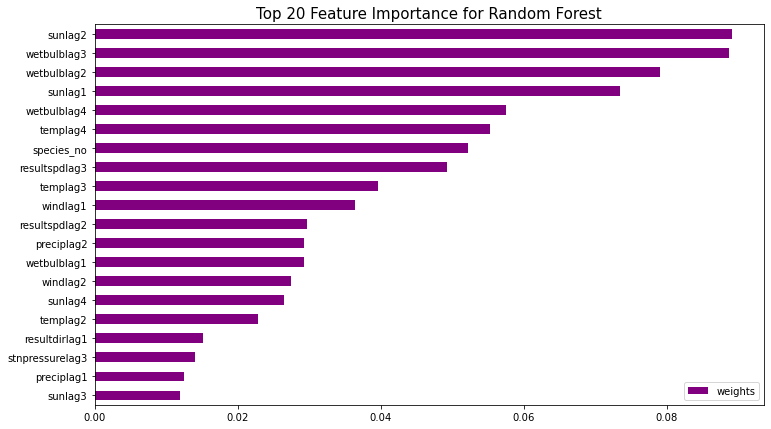

In [43]:
# Plotting Top 20 features in bar chart
imp_rf.head(20).plot(kind='barh', label=imp_rf.columns[:20], figsize=(12,7), color='purple')
plt.title('Top 20 Feature Importance for Random Forest', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

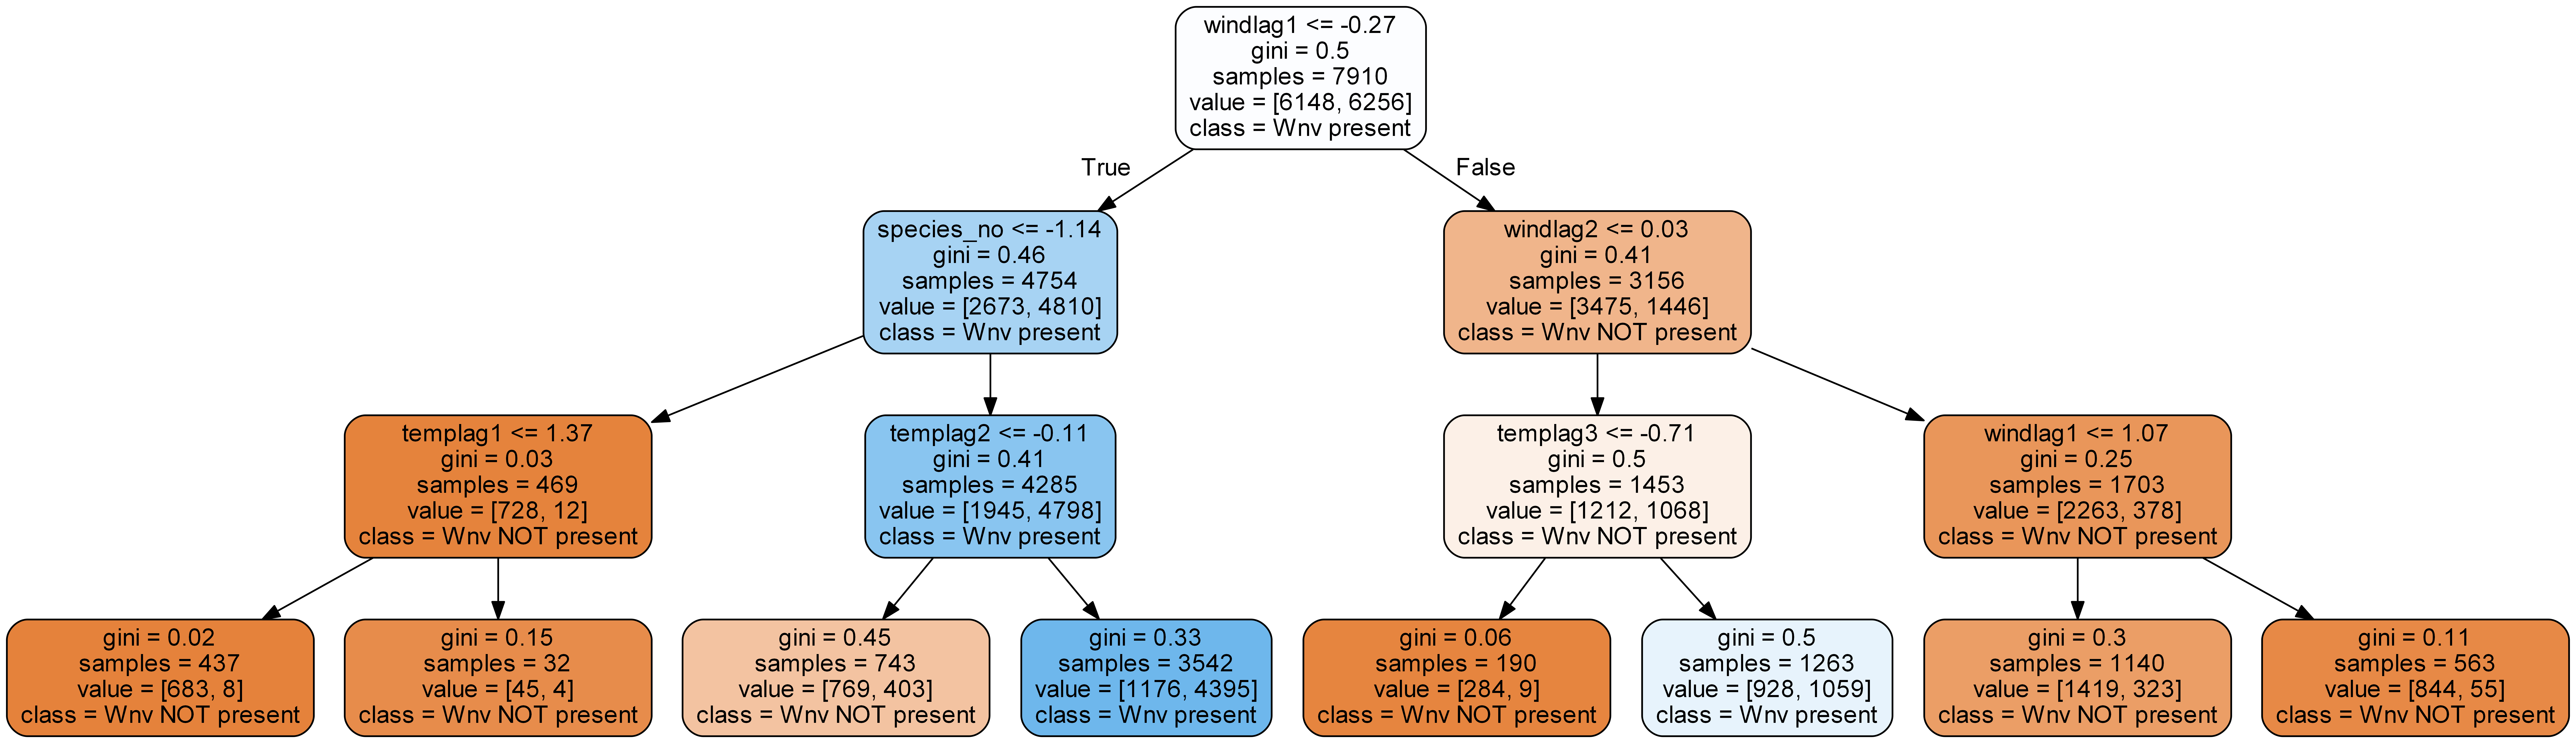

In [44]:
# Visualize decision trees for random forest
from sklearn.tree import export_graphviz

# Extract single tree
estimator = rf.estimators_[50]

# Export as dot file
dotfile = open("../images/tree.dot", 'w')
export_graphviz(estimator, out_file=dotfile, 
                feature_names = X_train.columns,
                class_names = ['Wnv NOT present', 'Wnv present'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)
dotfile.close()

# Convert to png using system command (requires Graphviz)
from subprocess import check_call
check_call(['dot', '-Tpng', '../images/tree.dot', '-o', '../images/tree.png', '-Gdpi=600'], shell=True)

# Display in jupyter notebook
from IPython.display import Image
Image(filename = '../images/tree.png')

Sun hours, wetbulb, species type, wind and temperature are the biggest factors that may affect the presence of the West Nile Virus (Wnv). The duration of the sun is a strong predictor for this model, suggesting that it greatly affects the activity of the mosquitoes. As expected, species type plays a major part in the prediction of Wnv since only 3 mosquito species showed that Wnv is present during the EDA. Temperature and wind are also important features here, suggesting that they affect the mosquitoes activity as well.

In [45]:
# Append to the lists
model_name.append('Random Forest')
model_scores.append(rf.score(Xsm_train, ysm_train))
model_var.append(rf)
model_test_scores.append(rf.score(Xs_test,y_test))

### Fitting ExtraTrees Classifier

In [46]:
# Pipeline
pipe_et = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('et', ExtraTreesClassifier(random_state=42))
    ])


# Hyperparameters
et_params = {
    'et__n_estimators': [80, 100, 120],
    'et__max_depth': [3, 5],
    'et__min_samples_leaf': [2, 4],
    'et__min_samples_split' : [2, 4]
}

In [47]:
# Instantiate 5-fold GridSearchCV.
gs_et = GridSearchCV(pipe_et, param_grid = et_params, cv=5,
                     scoring='roc_auc',n_jobs=-1,
                     verbose=1)

# Fit GridSearch to training data.
gs_et.fit(Xs_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   41.5s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                                       ('et',
                                        ExtraTreesClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'et__max_depth': [3, 5],
                         'et__min_samples_leaf': [2, 4],
                         'et__min_samples_split': [2, 4],
                         'et__n_estimators': [80, 100, 120]},
             scoring='roc_auc', verbose=1)

In [48]:
gs_et.best_estimator_

Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('et',
                 ExtraTreesClassifier(max_depth=3, min_samples_leaf=4,
                                      n_estimators=80, random_state=42))])

In [49]:
et = ExtraTreesClassifier(max_depth=3, min_samples_leaf=4, n_estimators=80,
                     random_state=42)
et.fit(Xsm_train, ysm_train)

ExtraTreesClassifier(max_depth=3, min_samples_leaf=4, n_estimators=80,
                     random_state=42)

#### Interpreting Extra Trees

In [50]:
imp_et = pd.DataFrame(et.feature_importances_,
                       index=X.columns,
                       columns=['weights']).sort_values(by='weights', ascending=False)

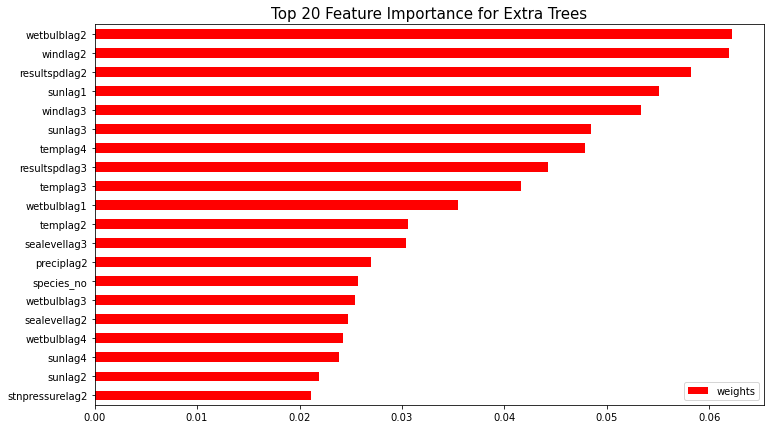

In [51]:
# Top 20 features
imp_et.head(20).plot(kind='barh', label=imp_et.columns, figsize=(12,7), color='red')
plt.title('Top 20 Feature Importance for Extra Trees', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

Sun hours, wetbulb, species type, wind and temperature are the biggest factors that may affect the presence of the West Nile Virus (Wnv). The duration of the sun is a strong predictor for this model, suggesting that it greatly affects the activity of the mosquitoes. As expected, species type plays a major part in the prediction of Wnv since only 3 mosquito species showed that Wnv is present during the EDA. Temperature and humidity are also important features here, suggesting that they affect the mosquitoes activity as well.

In [52]:
# Append to the lists
model_name.append('Extra Trees')
model_scores.append(et.score(Xsm_train, ysm_train))
model_var.append(et)
model_test_scores.append(et.score(Xs_test,y_test))

### Fitting AdaBoost Classifier

In [53]:
# Pipeline
pipe_ada = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('ada', AdaBoostClassifier(random_state=42))
    ])

# Hyperparameters
ada_params = {
    'ada__n_estimators': [20, 30, 40, 50],
    'ada__learning_rate': [0.8, 0.9, 1]
}

In [54]:
# Instantiate 5-fold GridSearchCV.
gs_ada = GridSearchCV(pipe_ada, param_grid = ada_params, cv=5,
                      scoring='roc_auc', n_jobs=-1,
                     verbose=1)

# Fit GridSearch to training data.
gs_ada.fit(Xs_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   37.3s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                                       ('ada',
                                        AdaBoostClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'ada__learning_rate': [0.8, 0.9, 1],
                         'ada__n_estimators': [20, 30, 40, 50]},
             scoring='roc_auc', verbose=1)

In [55]:
gs_ada.best_estimator_

Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('ada',
                 AdaBoostClassifier(learning_rate=1, n_estimators=20,
                                    random_state=42))])

In [56]:
ada = AdaBoostClassifier(learning_rate=1, n_estimators=20, random_state=42)
ada.fit(Xsm_train, ysm_train)

AdaBoostClassifier(learning_rate=1, n_estimators=20, random_state=42)

#### Interpreting AdaBoost

In [57]:
imp_ada = pd.DataFrame(ada.feature_importances_,
                       index=X.columns,
                       columns=['weights']).sort_values(by='weights', ascending=False)

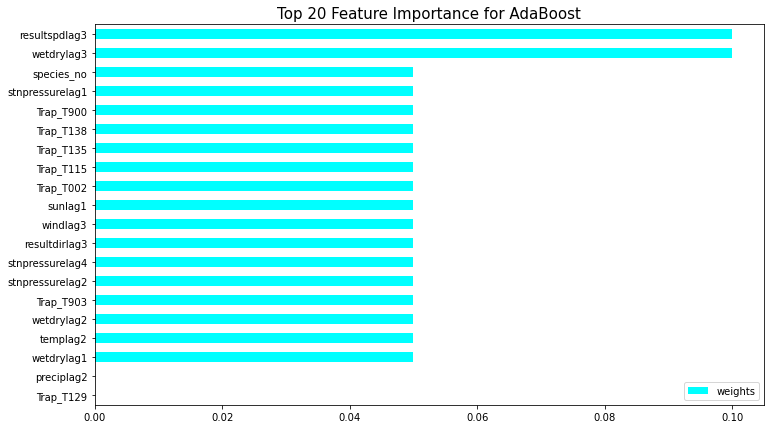

In [93]:
# Plot in bar chart
imp_ada.head(20).plot(kind='barh', label=imp_ada.columns[:20], figsize=(12,7), color='cyan')
plt.title('Top 20 Feature Importance for AdaBoost', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

Sun hours, species type, wetdry, humidity and temperature are the biggest factors that may affect the presence of the West Nile Virus (Wnv). As expected, species type plays a major part in the prediction of Wnv since only 3 mosquito species showed that Wnv is present during the EDA. The duration of the sun is a strong predictor for this model, suggesting that it greatly affects the activity of the mosquitoes. Temperature and humidity are also important features here, suggesting that they affect the mosquitoes activity as well.

In [59]:
# Append to the lists
model_name.append('AdaBoost')
model_scores.append(ada.score(Xsm_train, ysm_train))
model_var.append(ada)
model_test_scores.append(ada.score(Xs_test,y_test))

### Fitting Gradient Boost Classifier

In [60]:
# Pipeline
pipe_gboost = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('gboost', GradientBoostingClassifier())
    ])


# Hyperparameters
gboost_params = {
    'gboost__n_estimators': [80, 100, 120, 150],
    'gboost__max_depth': [1, 2, 3],
    'gboost__min_samples_split': [2, 4],
    'gboost__min_samples_leaf': [1, 2]
}

In [61]:
# Instantiate 5-fold GridSearchCV.
gs_gboost = GridSearchCV(pipe_gboost, param_grid = gboost_params, cv=5,
                         scoring='roc_auc',n_jobs=-1,
                     verbose=1)

# Fit GridSearch to training data.
gs_gboost.fit(Xs_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  9.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                                       ('gboost',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gboost__max_depth': [1, 2, 3],
                         'gboost__min_samples_leaf': [1, 2],
                         'gboost__min_samples_split': [2, 4],
                         'gboost__n_estimators': [80, 100, 120, 150]},
             scoring='roc_auc', verbose=1)

In [62]:
gs_gboost.best_estimator_

Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('gboost',
                 GradientBoostingClassifier(max_depth=1, n_estimators=150))])

In [63]:
gboost = GradientBoostingClassifier(min_samples_leaf=1, n_estimators=150)
gboost.fit(Xsm_train, ysm_train)

GradientBoostingClassifier(n_estimators=150)

#### Interpreting Gradient Boosting

In [64]:
imp_gboost = pd.DataFrame(gboost.feature_importances_,
                       index=X.columns,
                       columns=['weights']).sort_values(by='weights', ascending=False)

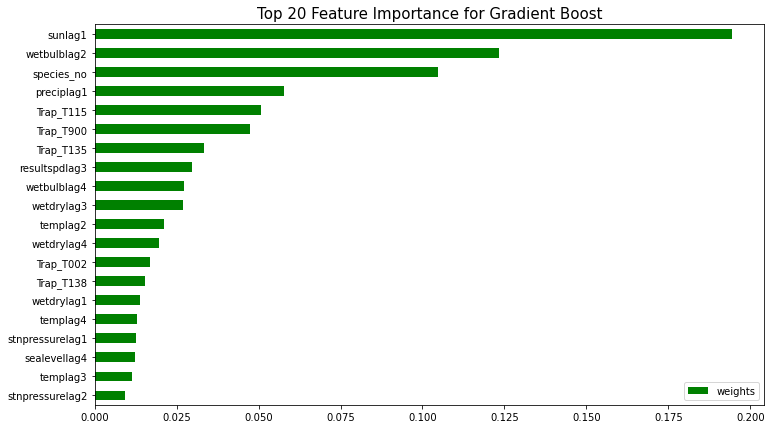

In [94]:
# Plot in bar chart
imp_gboost.head(20).plot(kind='barh', label=imp_gboost.columns[:20], figsize=(12,7), color='green')
plt.title('Top 20 Feature Importance for Gradient Boost', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

We see a similar trend here with the adaboost. Sun hours, species type, humidity and temperature are the biggest factors that may affect the presence of the West Nile Virus (Wnv). As expected, species type plays a major part in the prediction of Wnv since only 3 mosquito species showed that Wnv is present during the EDA. The duration of the sun is a strong predictor for this model, suggesting that it greatly affects the activity of the mosquitoes. Temperature and humidity are also important features here, suggesting that they affect the mosquitoes activity as well.

In [66]:
# Append to the lists
model_name.append('GradientBoosting')
model_scores.append(gboost.score(Xsm_train, ysm_train))
model_var.append(gboost)
model_test_scores.append(gboost.score(Xs_test, y_test))

### Fitting Support Vector Classifier

In [67]:
# Pipeline
pipe_svc = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('svc', SVC())
    ])


# Hyperparameters
svc_params = {
    'svc__C': [1, 0.1],
    'svc__kernel': ['rbf', 'poly'],
    'svc__degree': [2, 3]
}

In [68]:
# Instantiate 5-fold GridSearchCV.
gs_svc = GridSearchCV(pipe_svc, param_grid = svc_params, cv=5,
                      scoring='roc_auc',n_jobs=-1,
                     verbose=1)

# Fit GridSearch to training data.
gs_svc.fit(Xs_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.3min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': [1, 0.1], 'svc__degree': [2, 3],
                         'svc__kernel': ['rbf', 'poly']},
             scoring='roc_auc', verbose=1)

In [69]:
gs_svc.best_estimator_

Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('svc', SVC(C=0.1, degree=2))])

In [70]:
svc = SVC(C=0.1, degree=2)
svc.fit(Xsm_train, ysm_train)

SVC(C=0.1, degree=2)

In [71]:
# Append to the lists
model_name.append('Support Vector Classifier')
model_scores.append(svc.score(Xsm_train, ysm_train))
model_var.append(svc)
model_test_scores.append(svc.score(Xs_test,y_test))

We can conclude that the species type, the duration of the Sun, temperature, wind, humidity are the important factors. 

## Model Evaluation & Selection

We are more concerned with the ROC-AUC and Recall of each model. Despite that, the train and test accuracies are still useful for us to spot any overfitting within each model.

In [72]:
# View the evaluation metrics for all models in a dataframe
# Sorted by highest F1-Score
precision_list = []
recall_list = []
fscore_list = []
auc_list_train = []
auc_list_test = []
for model in model_var:
    y_pred = model.predict(Xs_test)
    y_pred_train = model.predict(Xs_train)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
    precision_list.append(precision)
    recall_list.append(recall)
    fscore_list.append(fscore)
    auc_list_train.append(roc_auc_score(y_train, y_pred_train))
    auc_list_test.append(roc_auc_score(y_test, y_pred))

pd.DataFrame({'Model Type': model_name,
              'Train AUC': auc_list_train,
              'Test AUC': auc_list_test,
              'F1-Score': fscore_list,
             'Recall': recall_list,
              'Precision': precision_list,
              'Train Accuracy': model_scores,
             'Test Accuracy': model_test_scores}).sort_values(by='Test AUC', ascending=False)

C:\Users\riche\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model Type,Train AUC,Test AUC,F1-Score,Recall,Precision,Train Accuracy,Test Accuracy
4,AdaBoost,0.768642,0.584945,0.555765,0.584945,0.550529,0.882780,0.794705
0,Logistic Regression,0.832545,0.584520,0.556905,0.584520,0.551264,0.888826,0.797956
6,Support Vector Classifier,0.860891,0.574051,0.572417,0.574051,0.570921,0.923331,0.851370
5,GradientBoosting,0.676681,0.520733,0.520463,0.520733,0.582550,0.967027,0.895495
2,Random Forest,0.752317,0.508107,0.493737,0.508107,0.635600,0.812802,0.904784
3,Extra Trees,0.755211,0.501450,0.479825,0.501450,0.553212,0.790310,0.904784
1,Naive Bayes,0.749913,0.500000,0.475390,0.500000,0.453089,0.797485,0.906177


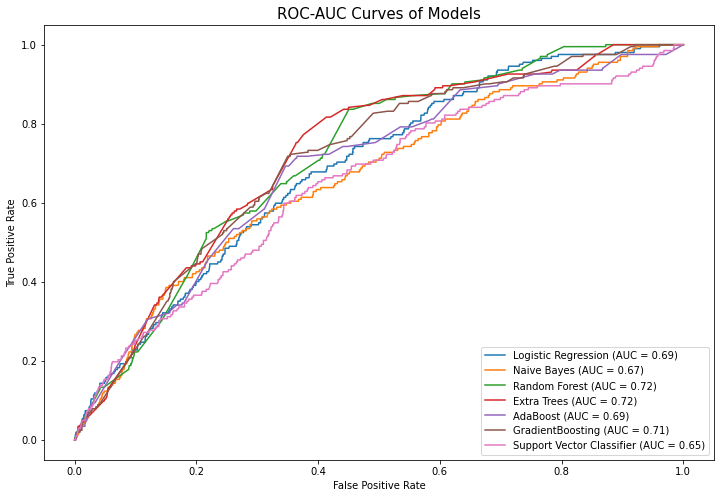

In [73]:
# Plotting the ROC curves for every model
plt.figure(figsize=(12,8))
ax = plt.gca()
for model, m_name in zip(model_var, model_name):
    plot_roc_curve(model, Xs_test, y_test, name=m_name, ax=ax)
plt.title('ROC-AUC Curves of Models', fontsize=15);

In [74]:
# Function to plot multiple confusion matrix
def subplot_confusion_matrix(model_list, model_name, X_test, y_test):
    nrows = int(np.ceil(len(model_list)/3))   # Ensure have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(14, nrows*4))   
    plt.subplots_adjust(hspace = 0.4)
    ax = ax.ravel()   # Ravel turns a matrix into a vector, which is easier to iterate
    for i, model in enumerate(model_list):   # Gives us an index value to get into all our lists
        plot_confusion_matrix(model, X_test, y_test, cmap='Blues', values_format='d', ax=ax[i])
        ax[i].set_title(model_name[i])
    
        # display scale and label only on the left edge
        if i%3 != 0:
            ax[i].set_ylabel('')
            ax[i].set_yticklabels('')
    # This code below is to switch off the axes if there is an odd number of subplots
    for axes in ax.flat[len(model_list):]:
        axes.axis('off')
    fig.tight_layout()
    pass

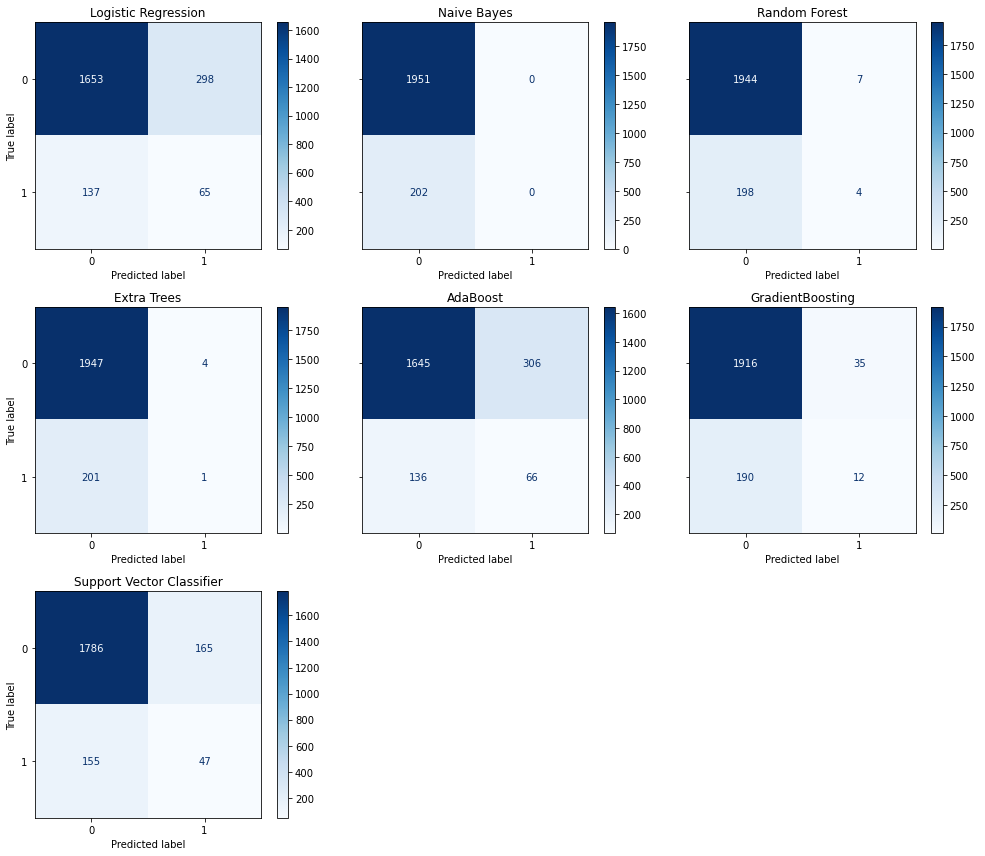

In [75]:
# Plotting confusion matrix for all models
subplot_confusion_matrix(model_var, model_name, Xs_test, y_test)

Because the target variable is heavily imbalanced, we could not reliably judge a model's performance based on accuracy and decided to optimize the models on ROC-AUC instead. ROC is a probability curve and AUC represents degree of measure of separability. It is a good measurement of how much the models are capable of distinguishing between the classes 0 and 1. The higher the AUC, the better the model is at predicting the class correctly. Putting into context, the higher the AUC, the better the model is at distinguishing between mosquito traps with Wnv present and Wnv NOT present.

From the ROC-AUC scores above, we observed that the AdaBoost model had the highest Test AUC score. It is very close to 1, indicating that it is a good model at predicting the classes correctly. Also, AdaBoost has the highest [recall](https://en.wikipedia.org/wiki/Precision_and_recall) score, which represents the fraction of retrieved relevant instances among all relevant instances. In other words, it measures the proportion of positives that are correctly identified (i.e. the proportion of data entries predicted at Wnv present and are truly Wnv present). Furthermore, AdaBoost model has the lowest number of False Negatives (i.e. predicting that Wnv is not present when it is actually present), which is the most important due to some reason. In our opinion, it is unethical to tell the public that a certain location do not have presence of Wnv when there is actually Wnv present. As such, having a very small number of False Negatives is very important. Although there is a relatively large difference between the train and test accuracies which suggests overfitting, it is still acceptable by our means, also taking into account that this is common for AdaBoost model.

Therefore, we will select **AdaBoost** as the production model for predict the presence of the West Nile Virus.

**AdaBoost Summary**  
[Adaptive Boosting](https://corporatefinanceinstitute.com/resources/knowledge/other/boosting/), otherwise known as AdaBoost, aims at combining several weak learners to form a single strong learner. Adaboost concentrates on weak learners, which are often [decision trees](https://en.wikipedia.org/wiki/Decision_tree#:~:text=A%20decision%20tree%20is%20a%20flowchart%2Dlike%20structure%20in%20which,taken%20after%20computing%20all%20attributes) with only one split and are commonly referred to as decision stumps. The first decision stump in AdaBoost contains observations that are weighted equally.

Previous errors are corrected, and any observations that were classified incorrectly are assigned more weight than other observations that had no error in classification. An error noticed in previous models is adjusted with weighting until an accurate predictor is made.

Advantages:  
* Prediction interpretations are easy to handle.
* Resilient method that reduces bias.

Disadvantages:  
* Sensitive to outliers since every classifier is obliged to fix the errors of the predecessors. In this project, we have dealt with the potential outliers via EDA and cleaned the data enough such that this is not so much an issue.
* Almost impossible to scale up because every estimator bases its correctness on the previous predictors, making the procedure difficult to streamline. This is not so much a concern in this project since we are investigating a single area with a specific set of conditions. If we were to analyse another location, all the variables, such as weather conditions, would be different anyway.
* Computationally expensive for large datasets. Although the model took one of the longest to fit, the dataset in this project is still of a manageable size which most computers can use to run.

In [76]:
# Assign the selected production model
production_model = ada

In [77]:
# Save scaler as a pickle file
outfile = open('scaler.pkl','wb')
pickle.dump(ss, outfile)
outfile.close()

In [78]:
# Save model as a pickle file
outfile = open('production_model.pkl','wb')
pickle.dump(production_model, outfile)
outfile.close()

## Deep Learning with Neural Network

For the sake of exploration, we want to develop a neural network to see if we are able to achieve a better scoring model.

In [79]:
# Instantiate a NN.
nn = Sequential()

# Input layer
nn.add(Dense(Xsm_train.shape[1], activation='relu', input_dim=Xsm_train.shape[1]))

nn.add(Dropout(0.5))
nn.add(Dense(128, activation='relu'))
nn.add(Dropout(0.5))
nn.add(Dense(64, activation='relu'))
nn.add(Dropout(0.5))
nn.add(Dense(32, activation='relu'))
nn.add(Dropout(0.5))
nn.add(Dense(16, activation='relu'))

# Output layer
nn.add(Dense(1, activation='sigmoid')) 

# Compile it
nn.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.005), metrics=['AUC'])

early_stop = EarlyStopping(monitor='val_auc', min_delta=0.02, patience=5, mode='auto')

nn.fit(Xsm_train, ysm_train, batch_size=32, validation_data=(Xs_test, y_test),
                          epochs=100,
                          callbacks=[early_stop],
                          verbose=1)

Epoch 1/100
388/388 [==============================] - 1s 3ms/step - loss: 0.3902 - auc: 0.9036 - val_loss: 0.5549 - val_auc: 0.6658
Epoch 2/100
388/388 [==============================] - 1s 2ms/step - loss: 0.2243 - auc: 0.9592 - val_loss: 0.9983 - val_auc: 0.6046
Epoch 3/100
388/388 [==============================] - 1s 2ms/step - loss: 0.1935 - auc: 0.9679 - val_loss: 0.7828 - val_auc: 0.6226
Epoch 4/100
388/388 [==============================] - 1s 2ms/step - loss: 0.1670 - auc: 0.9725 - val_loss: 0.5514 - val_auc: 0.6608
Epoch 5/100
388/388 [==============================] - 1s 2ms/step - loss: 0.1589 - auc: 0.9752 - val_loss: 1.3814 - val_auc: 0.5841
Epoch 6/100
388/388 [==============================] - 1s 2ms/step - loss: 0.1582 - auc: 0.9738 - val_loss: 0.5535 - val_auc: 0.6541
Epoch 7/100
388/388 [==============================] - 1s 2ms/step - loss: 0.1559 - auc: 0.9730 - val_loss: 1.1502 - val_auc: 0.5970
Epoch 8/100
388/388 [==============================] - 1s 2ms/step - 

In [95]:
# Check layers in summary
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 182)               33306     
_________________________________________________________________
dropout (Dropout)            (None, 182)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               23424     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2

In [80]:
# Predict y test using NN model, round off prediction to either 0 or 1
y_pred=np.round(nn.predict(Xs_test),0)

In [81]:
# Get NN results
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
nn_recall = tp / (tp+fn)
nn_precision = tp / (tp+fp)
nn_f1 = 2 * (nn_precision * nn_recall)/(nn_precision + nn_recall)
nn_auc = roc_auc_score(y_test, y_pred)
print('Results for NN Model\n'+'-'*25)
print('AUC: {:.4f}'.format(nn_auc))
print('F1-Score: {:.4f}'.format(nn_f1))
print('Recall: {:.4f}'.format(nn_recall))
print('Precision: {:.4f}'.format(nn_precision))

Results for NN Model
-------------------------
AUC: 0.5386
F1-Score: 0.1593
Recall: 0.1337
Precision: 0.1971


After predicting the results using the neural network, we observed that the scoring metrics are actually not as high as our production model. This could be due to the small number of neural network layers and its low complexity. If given a much longer timeframe, it is definitely possible to build a neural network with a very high AUC score. However, in this project we will stick with our production model since it could be interpreted more easily as compared to a neural network.

## Conclusions

Through this project, we gained many useful insights about the mosquito population in the Windy City and its relation to the epidemic of West Nile Virus (Wnv). Using the data on mosquito traps, weather and pesticide spraying, we were able to develop several models with tuned hyperparameters to classify whether Wnv is present or not. In the process of finding the best model for predicting the presence of Wnv, we found that the species type, the duration of the Sun, temperature, wind, humidity are  consistently strong predictors across the models. Based on [research](https://www.health.ny.gov/publications/2746/#:~:text=Some%20mosquitoes%20are%20active%20between,fall%20in%20New%20York%20State.), mosquitoes are active between dusk and dawn, when the air is calm. This is synonymous with the interpretations which we did on the various models, where the presence of Wnv is more prevalent when the sun has set. Another important factor to the presence of Wnv is the mosquito species, where we observed that culex pipiens and culex restuans mosquitoes are strong vectors of spreading the Wnv. Other studies further substantiated these observations, affirming that these mosquito species are the main vectors for the Wnv and there is similar vector competence between the two [[source 1](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3485754/)][[source 2](https://pubmed.ncbi.nlm.nih.gov/16363169/)]. In addition, [research](https://www.mosquitosquad.com/central-illinois/about-us/blog/2018/july/how-does-weather-affect-mosquito-activity-/#:~:text=Heat%20and%20humidity&text=Temperature%20and%20mosquito%20activity%20goes,hard%20to%20function%20at%20all.) showed that mosquitoes flourish in moist, relatively warm environments and a less windy environment enables mosquitoes to navigate easily to feed on humans.

The production model which we ended up with was one using the **AdaBoost** algorithm. It has a high AUC score and a Recall Score. We did not compare the accuracy of this model to the baseline prediction since the data was heavily imbalanced in the first place (>95% of one class). The imbalances were dealt with using the SMOTE technique.

We also built a neural network to see if it could score better than our production model. However, within the limited timeframe of this project, we were only able to develop a simple neural network with manageable complexity. As a result, the AUC score achieved by the neural network was still lower than that of our production model. We also decided not to further refine the neural network since it is not as easily interpretable.

### Cost-benefit Analysis

We engineered a `trap-sprayed` feature prior to model development. It was a strong predictor of the presence of the Wnv in some of the models, suggesting that spraying was effective in dealing with the Wnv to a large extent.

INCLUDE annual cost projections for various levels of pesticide coverage (cost) and the effect of these various levels of pesticide coverage.

In [45]:
# Cost to spray the whole chicago with spray trucks
Cost_no_model = round(149770.57*0.92,2)*12
Cost_no_model

1653467.04

The Chicago Department of Public Health (CDPH) is continuing its efforts to protect residents against West Nile virus. The spray is done at dusk all through to approximately 1am. The pesticide used for spraying to control the mosquitoes is Zenivex E4. [[City of Chicago]](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_communities/news/2020/august/city-to-spray-insecticide-thursday-to-kill-mosquitoes0.html) [[nbcchicago]](https://www.nbcchicago.com/news/local/city-to-spray-mosquito-killing-insecticide-wednesday-night/64951/) Zenivex E4 has a 4% solution of etofenprox that does not contain piperonyl butoxide, which presents minimal risk to humans and non-target species.[[CMMCP]](https://www.cmmcp.org/pesticide-information/pages/zenivex-e4-etofenprox) The price of Zenivex E4 is \$0.92 per acre. [[Zenivex Pricing Brochure]](file:///Users/becksphan/Downloads/2015%20Zenivex%20Pricing%20Brochure.pdf) Without the model, to prevent West Nile Virus in the whole Chicago with an area of 149770.57 acres, it would cost approximately \$137,788.92 each time. Each year, it is advised not to spray more than 25 times per site. [[Zenivex]](http://www.mercercounty.org/home/showdocument?id=2626#:~:text=Do%20not%20spray%20more%20than,applications%20per%20site%20per%20year.) Depending on the weather and environmental conditions, mosquito treatment can last up to 30 days.[[NorthWest]](https://www.callnorthwest.com/2019/05/how-long-does-a-mosquito-treatment-last/) If we spray once per month to control the mosquitoes, the per year cost would be \$1,653,467.04.

In [46]:
# calculation of the area around the trap to spray to cover the required area
pi = 3.14
r = 700
area = pi*(r**2)
area

1538600.0

In [47]:
# Converting the area to acres
sq_ft_acres = 43560
acres_area = area/sq_ft_acres
acres_area

35.321395775941234

In [48]:
# Calculate the cost to spray the area around a trap using backpacks
cost_per_trap = acres_area*0.92

In [49]:
# Calculate the total cost to spray all the traps predicted by the production model for 1 year
cost_traps = round((66+306)*cost_per_trap,2)*12
cost_traps

145060.68

In [50]:
# Total short-term hospitalization costs
st_hosp = 7500*25
st_hosp

187500

In [51]:
# Total loss of economic productivity costs
prod_loss = round(((37103/365)*42)*25,2)
prod_loss

106734.66

In [52]:
young_cost = st_hosp + prod_loss
round(young_cost,2)

294234.66

In [53]:
# Total long-term hospitalization costs
lt_hosp = (25000)*25
lt_hosp

625000

In [54]:
# Total cost utilizing the production model
Cost_model = ((young_cost + lt_hosp)/2)+cost_traps
round(Cost_model,2)

604678.01

In [55]:
# Cost difference between spraying the whole chicago and targeted spraying
Cost_no_model - Cost_model

1048789.03

The cost to spray at a trap would be <i>(if we want to cover a radius of about 3.2km which is about 10,000ft since the culex pipiens are known to fly up to that range [CDC](https://www.cdc.gov/mosquitoes/about/life-cycles/culex.html#:~:text=Culex%20mosquitoes%20don't%20fly,live%20near%20and%20bite%20birds.)
around the trap, the spray dispersement can cover to 300ft, therefore we need to spray and area of 700ft)</i> \$32.50 to cover an area of about 35 acres around a trap.

If we were to use our production model (AdaBoost), the total cost would be:
> **Direct cost**:<br>66(TP) + 306(FP) = $145,060.68 for 1 year

> **Indirect cost:**<br>
Lost of productivity when people fall severely sick due to the virus as well as the medical cost from it. "About 1 in 5 people who are infected with the virus will develop a fever with other symptoms such as headache and joint pains, but about one in 150 of those infected develop a serious nervous system illness such as encephalitis or meningitis that typically requires hospitalization". Of those 1 in 150 infected, those who were younger, tend to recover faster and have shorter hospital stays but would have higher economic cost in lost productivity as they would need to take leave from work, whereas those older tend to stay longer, however tend not to have any cost associated with lost productivity as most of them might be retired. [[ScienceDaily]](https://www.sciencedaily.com/releases/2014/02/140210184713.htm#:~:text=In%20a%20study%20of%20the,care%20expenditures%20and%20lost%20productivity.)  <br>In year 2020, 25 cases of the west nile virus was reported in Chicago. [[abc7chicago]](https://abc7chicago.com/health/chicagoan-becomes-1st-2020-west-nile-virus-il-death/6889047/) If we assume that all the cases involved young and working adults, and were hospitalized for short-term, the medical cost with a median initial hospitalization cost of \\$7,500, would be approximately \\$187,500. [[ScienceDaily]](https://www.sciencedaily.com/releases/2014/02/140210184713.htm#:~:text=In%20a%20study%20of%20the,care%20expenditures%20and%20lost%20productivity.) Referencing the per capita income of 2019[[Census]](https://www.census.gov/quickfacts/chicagocityillinois), which is \\$37,103 and hospitalized patients were absent from work for a median 42 days due to their illness[[ScienceDaily]](https://www.sciencedaily.com/releases/2014/02/140210184713.htm#:~:text=In%20a%20study%20of%20the,care%20expenditures%20and%20lost%20productivity.), resulting in the loss of productivity for 25 young adults being \\$106,734.66. Therefore, the total cost assuming all 25 patients are young and stayed in the hospitals for a short period is \\$294,234.66. However, if these 25 cases involved all elderlies, the max cost for medical would be \\$625,000. 

> **Total cost:**<br>
Taking the average of the 2 scenarios (\\$459,617.33) plus the direct cost(\\$145,060.68). This would amount to $604,678.01.

Using the model for targeted spraying would approximately save $1,048,789.03, which could go to increasing number of catch basins or maintenance of it to improve collection of data for further predictions. 

If spraying on a city level, benefits for spraying includes improved quality of life due to reduction in the chances of getting ill due to the virus. This would save the loss of production and medical costs associated with the virus which amounts to \\$459,617.33 and quality of life would improve. Medical costs saved could be targeted towards other medical cause. \\$145,060.68 for the cost of spraying predicted area could spray an area of 157,674.57 acres.

### Moving Forward

Further studies could be done if we had data on the human demographics within the area. It could be easily hypothesized that higher human population and density would increase the probability of a Wnv case. More geographic information could also be useful in studying the presence of Wnv. Since Wnv is spread through moquitoes, we could expect that proportion of open water sources, percentage of grass land, forests, and urban landscape are all factors of the livelihood of these mosquitoes.

The data which we studied only included the culex moquito species, because it is more prominent in the city of Chicago. If we were to expand our studies to the rest of the United States, data on more mosquito species could be useful, such as the Culex Tarsalis and Culex Quinquefasciatus. These species are found to be the [main vector species](https://www.vdci.net/vector-borne-diseases/west-nile-virus-education-and-mosquito-management-to-protect-public-health/) in the United States. Although Culex mosquitoes are accepted as the primary global transmission vector, it is possible for other mosquito species to acquire and transmit Wnv. There are reports of Wnv in Aedes mosquitoes as well and data on more mosquitoes species could paint us a more complete picture [[source](https://www.vdci.net/vector-borne-diseases/west-nile-virus-education-and-mosquito-management-to-protect-public-health/)].